In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import os
from PIL import Image
import random

In [2]:
# sapi
# direktori train test
train_dir= r'D:\BANGKIT2023\CAPSTONE\sapiseimbang\train'
test_dir= r'D:\BANGKIT2023\CAPSTONE\sapiseimbang\test'

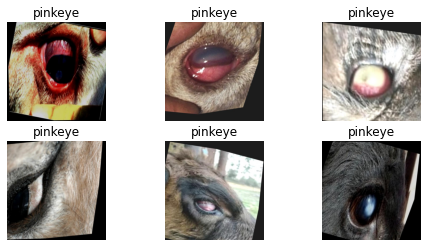

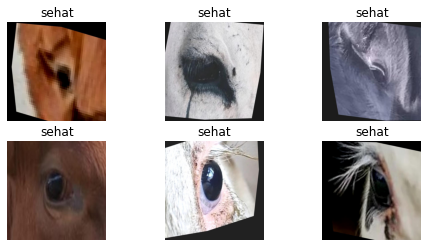

In [3]:
# list nama kelas
class_name = 'pinkeye'
class_name2 = 'sehat'

# list path gambar pada kelas yang dipilih
image_paths = os.listdir(os.path.join(train_dir, class_name))
image_paths2 = os.listdir(os.path.join(train_dir, class_name2))

# memilih 6 gambar secara acak dari kelas yang dipilih
image_paths = random.sample(image_paths, 6)
image_paths2 = random.sample(image_paths2, 6)

# menampilkan 6 gambar dari kelas yang dipilih
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name, image_paths[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name}")
    ax.axis('off')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name2, image_paths2[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name2}")
    ax.axis('off')
plt.show()

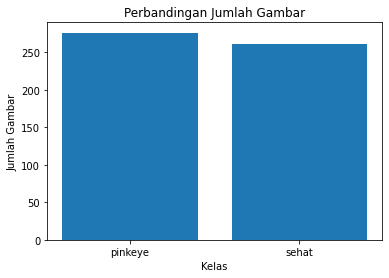

jumlah gambar sapi pinkeye =  276
jumlah gambar sapi sehat =  261


In [4]:
class_names = ['pinkeye', 'sehat']

# menghitung jumlah gambar pada setiap kelas
num_images = []
for class_name in class_names:
    num_images.append(len(os.listdir(os.path.join(train_dir, class_name))))

# menampilkan grafik perbandingan jumlah gambar pada dua kelas
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(class_names, num_images)
ax.set_title('Perbandingan Jumlah Gambar')
ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Gambar')
plt.show()
print('jumlah gambar sapi pinkeye = ',num_images[0])
print('jumlah gambar sapi sehat = ',num_images[1])

In [5]:
# ukuran gambar dan batch nantinya
image_size = 224
batch_size = 32

In [6]:
# augmentasi data train
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=24,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   zoom_range=0.2,
                                   horizontal_flip=False)

# yang tes cmn rescale aja
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# mempersiapkan data di preprosesing untuk train dan tes nantinya
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='binary')


Found 537 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


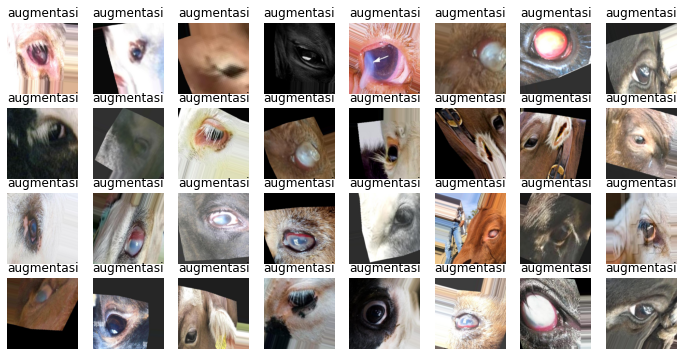

Jumlah gambar hasil augmentasi: 544


In [8]:
augmented_images, _ = train_generator.next()

# memvisualisasikan gambar setelah augmentasi
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.set_title('augmentasi')
    ax.imshow(augmented_images[i])
    ax.axis('off')
plt.show()
num_augmented_images = len(train_generator)* batch_size
print("Jumlah gambar hasil augmentasi:", num_augmented_images)

In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [41]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from tensorflow.keras.optimizers import SGD
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
num_epochs = 10

from tensorflow.keras.callbacks import Callback

class AccuracyCallback(Callback):
    def __init__(self, threshold):
        super(AccuracyCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] >= self.threshold:
            self.model.stop_training = True
            print(f"\nTraining stopped as validation accuracy reached {self.threshold}")


accuracy_callback = AccuracyCallback(threshold=0.94)

# early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', baseline=0.94)
# reduce_lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_delta=0.001, min_lr=0.0001)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / batch_size),
    callbacks=[accuracy_callback]
)


Epoch 1/10
16/16 [==============================] - 9s 583ms/step - loss: 0.0727 - accuracy: 0.9663 - val_loss: 0.1688 - val_accuracy: 0.9643
Epoch 2/10
16/16 [==============================] - 9s 581ms/step - loss: 0.0621 - accuracy: 0.9782 - val_loss: 0.1639 - val_accuracy: 0.9643
Epoch 3/10
16/16 [==============================] - 10s 598ms/step - loss: 0.0753 - accuracy: 0.9762 - val_loss: 0.1926 - val_accuracy: 0.9286
Epoch 4/10
16/16 [==============================] - 10s 590ms/step - loss: 0.0770 - accuracy: 0.9668 - val_loss: 0.1662 - val_accuracy: 0.9643
Epoch 5/10
16/16 [==============================] - 9s 577ms/step - loss: 0.0552 - accuracy: 0.9842 - val_loss: 0.1722 - val_accuracy: 0.9643
Epoch 6/10
16/16 [==============================] - 9s 581ms/step - loss: 0.0885 - accuracy: 0.9604 - val_loss: 0.1643 - val_accuracy: 0.9643
Epoch 7/10
16/16 [==============================] - 10s 595ms/step - loss: 0.0648 - accuracy: 0.9842 - val_loss: 0.1551 - val_accuracy: 0.9643
Epo

In [62]:
test_loss, test_acc = model.evaluate(validation_generator)
print('akurasi:', test_acc)

1/1 [==============================] - 0s 446ms/step - loss: 0.1491 - accuracy: 0.9643
akurasi: 0.9642857313156128


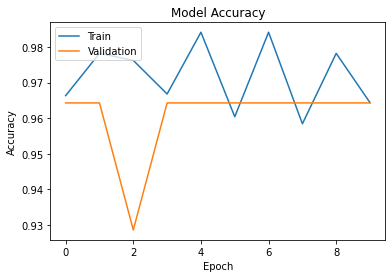

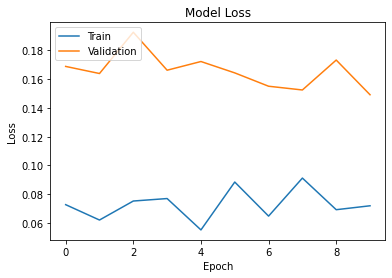

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 [==============================] - 0s 363ms/step
Confusion Matrix:
[[20  0]
 [ 1  7]]
1/1 [==============================] - 0s 394ms/step


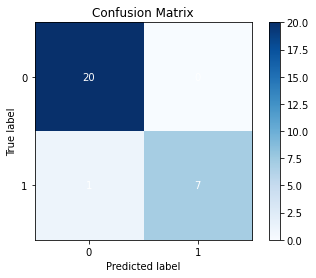

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions for the test set
test_images, test_labels = validation_generator.next()
predictions = model.predict(test_images) 

# Convert predicted probabilities to class labels
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)



# Generate predictions for the test set
test_images, test_labels = validation_generator.next()
predictions = model.predict(test_images)  

# Convert predicted probabilities to class labels
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix as a table
im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(cm[0])))
ax.set_yticks(np.arange(len(cm)))
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Add labels to each cell in the table
for i in range(len(cm)):
    for j in range(len(cm[0])):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='white')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the title
ax.set_title('Confusion Matrix')

# Display the plot
plt.show()


1/1 [==============================] - 0s 359ms/step
Confusion Matrix:
[[20  0]
 [ 1  7]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        20
         1.0       1.00      0.88      0.93         8

    accuracy                           0.96        28
   macro avg       0.98      0.94      0.95        28
weighted avg       0.97      0.96      0.96        28



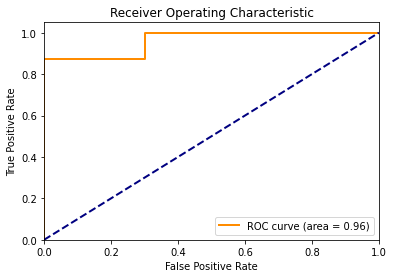

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
# Generate predictions for the test set
test_images, test_labels = validation_generator.next()
predictions = model.predict(test_images)

# Convert predicted probabilities to class labels
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Compute classification report
report = classification_report(test_labels, predicted_labels)
print("Classification Report:")
print(report)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 1s 1s/step


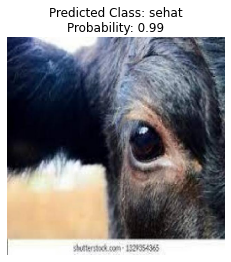

In [ ]:
import matplotlib.pyplot as plt

# ambil dan prepros
test_image_path = r'D:\BANGKIT2023\CAPSTONE\sapires\test\sehat\bmbm__jpg.rf.d751e9e0eb8ecc3ac0abcf9f245852f2.jpg' 
test_image = image.load_img(test_image_path, target_size=(image_size, image_size))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize the image

# Memprediksi
predictions = model.predict(test_image)

# probability
predicted_class = "pinkeye" if predictions[0][0] < 0.5 else "sehat" 
probability = predictions[0][0]

# tampil
plt.imshow(test_image[0])
plt.title(f'Predicted Class: {predicted_class}\nProbability: {probability:.2f}')
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 67ms/step


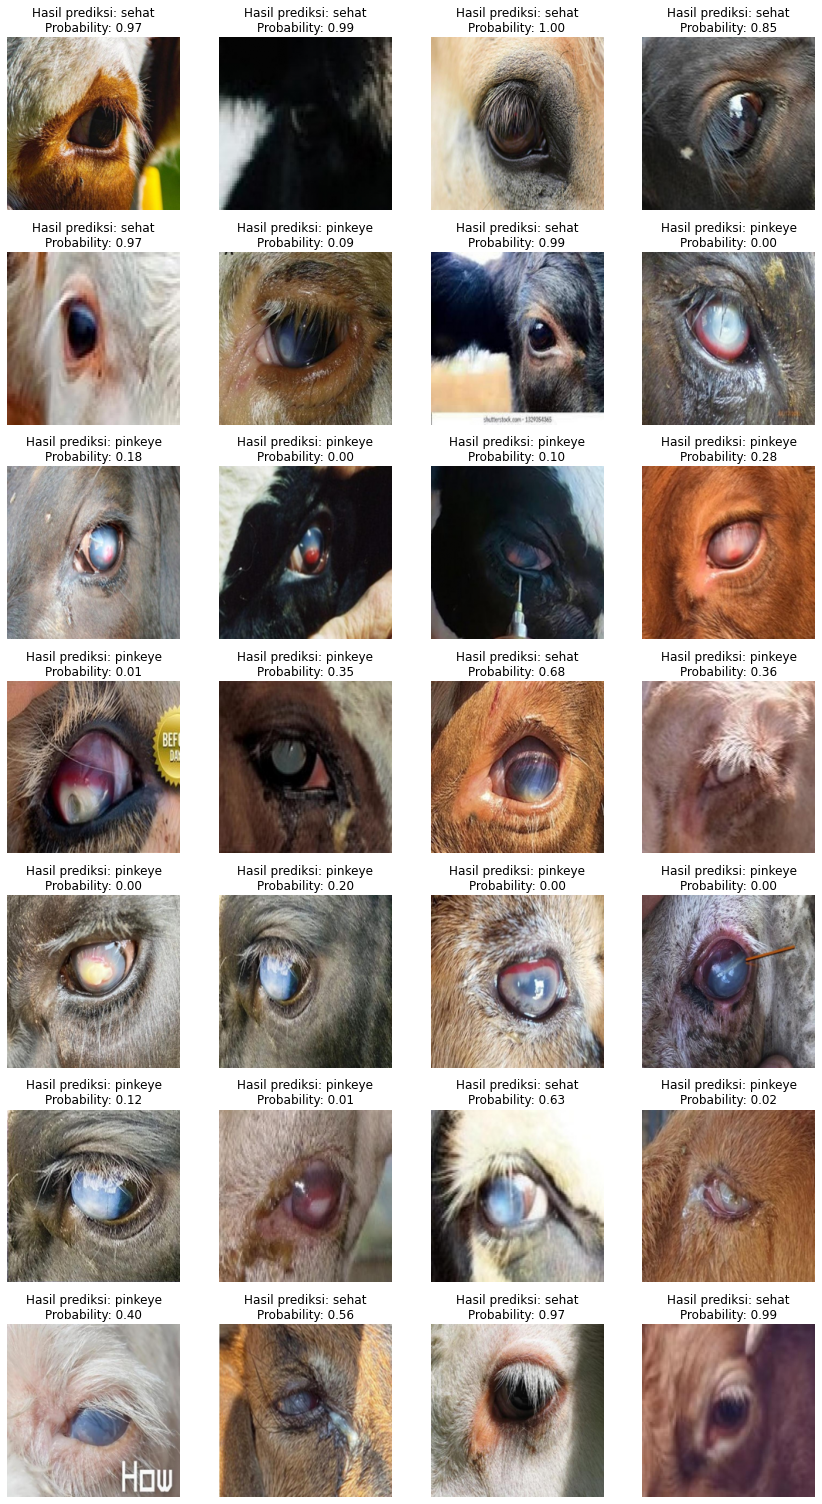

In [ ]:
import os
from PIL import Image

# Mendapatkan daftar semua file gambar dalam folder tes
folder_path = r'D:\BANGKIT2023\CAPSTONE\foltes'
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Mengatur ukuran subplot berdasarkan jumlah gambar
num_images = len(image_files)
num_cols = 4
num_rows = (num_images + num_cols - 1) // num_cols

# Membuat subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows))

# Loop melalui setiap file gambar
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)

    # Memuat dan memproses gambar
    test_image = Image.open(image_path)
    test_image = test_image.resize((image_size, image_size))
    test_image = np.array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image / 255.0  # Normalize the image

    # Memprediksi
    predictions = model.predict(test_image)

    # Probability dan kelas prediksi
    predicted_class = "pinkeye" if predictions[0][0] < 0.5 else "sehat" 
    probability = predictions[0][0]

    # Menampilkan gambar dan hasil prediksi dalam subplot
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(test_image[0])
    ax.set_title(f'Hasil prediksi: {predicted_class}\nProbability: {probability:.2f}')
    ax.axis('off')

# Menghapus subplot yang tidak digunakan
if num_images < num_rows * num_cols:
    for i in range(num_images, num_rows * num_cols):
        fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show()



In [ ]:
# model.save('model/sapifitmobilenet3.h5')